In [3]:
import numpy as np
import scipy as sp
from importlib import reload
import neuraltda.topology2 as tp2
import neuraltda.spikeutils as su
import glob
import os
import matplotlib.pyplot as plt

import subprocess as sp
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns  # for aesthetic

import neuraltda.topology2 as tp2
import neuraltda.spectralAnalysis as sa
import neuraltda.simpComp as sc
import numpy as np
import tempfile
import h5py as h5
import glob
import os
from importlib import reload
import tqdm
%matplotlib inline

sns.set_style('ticks')

import datetime
daystr = datetime.datetime.now().strftime('%Y%m%d')
figsavepth = '/home/brad/DailyLog/'+daystr+'/'
print(figsavepth)


/home/brad/DailyLog/20170912/


In [4]:
block_path = '/home/brad/krista/B1075/P01S03/'
block_path = '/home/brad/krista/B1083/P03S03/'
bdf = glob.glob('/home/brad/krista/B1083/P03S03/binned_data/win-10.0_dtovr-5.0_seg-0-0-fulltrial/20170626T223014Z-10.0-5.0.binned')[0]

# 4 birds, 4 Bettis, all stim on one chart 
birds = ['B1083', 'B1075', 'B1235', 'B1056']
bps = {'B1083': '/home/brad/krista/B1083/P03S03/', 'B1075': '/home/brad/krista/B1075/P01S03/',
       'B1235': '/home/brad/krista/B1235/P02S01/', 'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/',
       'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/'}

#bin the data
winsize = 10.0
dtovr = winsize*0.5
comment = 'ForBettiCurves'
segment_info = [0,0]
bdfs = {}

for bird in birds:
    block_path = bps[bird]
    bfdict = tp2.dag_bin(block_path, winsize, segment_info, cluster_group=['Good'], dt_overlap=dtovr, comment=comment)
    bdf = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]
    print(bdf)
    bdfs[bird] = bdf

/home/brad/krista/B1083/P03S03/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForBettiCurves/20170828T161341Z-10.0-5.0.binned
/home/brad/krista/B1075/P01S03/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForBettiCurves/20170828T161350Z-10.0-5.0.binned
/home/brad/krista/B1235/P02S01/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForBettiCurves/20170828T161356Z-10.0-5.0.binned
/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForBettiCurves/20170825T211415Z-10.0-5.0.binned


In [5]:
bird = 'B1083'
bdf = bdfs[bird]
block_path = bps[bird]

In [6]:
#Compute betti curves
reload(tp2)
analysis_id = 'test2'
thresh = 13.0
nperms = None
ncellsperm = 20
dim = [0,1, 2,3,4]
Ntimes = 1000

windt = 10.0
dtovr = windt*0.5
stimlen = 6000 #ms
twin = np.linspace(0, stimlen, Ntimes)

(bc, t, t_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
                                         thresh, nperms, ncellsperm,
                                         dim, twin, windt, dtovr, shuffle=False)
#shuffle
(bcs, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
                                            thresh, nperms, ncellsperm,
                                            dim, twin, windt, dtovr, shuffle=True)



In [10]:
reload(tp2)
# compute real and shuffled betti curves - TrialAverage
print('Computing trial average')
(bc_tavg, t, tms) = tp2.compute_trialaverage_betti_curves('ForSCMControl', block_path, bdf, thresh, nperms, ncellsperm, dim, twin, windt, dtovr)
(bc_tavg_shuff, t, tms) = tp2.compute_trialaverage_betti_curves('ForSCMControl-Shuffle', block_path, bdf, thresh, nperms, ncellsperm, dim, twin, windt, dtovr, shuffle=True)

Computing trial average


In [7]:
def plot_scm_distribution(scm_bettis, trial, bettinum, maxbin=200, ax=None, **kwargs):
    nmaxtot = 0
    scm_trial_bettis = scm_bettis[trial]
    bettivals = []
    try:
        for x in scm_trial_bettis:
            try:
                bettivals.append(x[0][bettinum])
            except IndexError:
                bettivals.append(0)
    except IndexError:
        bettivals = [x[bettinum] for x in scm_trial_bettis]
    bettivals2 = []
    for x in bettivals:
        if type(x) is not list:
            bettivals2.append(x)
        else:
            bettivals2.append(x[0])
    #print(bettivals)
    maxbettival = np.amax(bettivals2)
    maxbin = round(1.5*maxbettival)
    print(maxbin)
    bins = np.arange(maxbin)
    (n, bins2, ptaches) = ax.hist(bettivals2, bins, normed=True, stacked=True, **kwargs)
    #print(n)
    nmax = np.amax(n)
    nmaxtot = np.amax([nmax, nmaxtot])
    nmaxx = np.amax(bins)
    return (nmaxtot, nmaxx)

In [8]:
# Import scm data
import pickle
with open(os.path.join(block_path,'scm_control_save_trialvg.pkl'), 'rb') as f:
    stim_scm_dict = pickle.load(f)


4.0
4.0
4.0


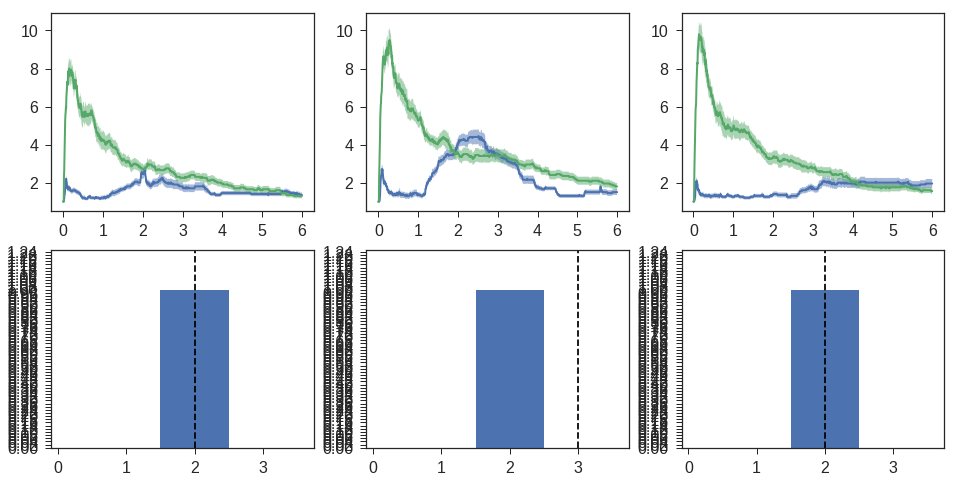

In [30]:
f, axs = plt.subplots(2, 3, figsize=(16, 8))
betti_num = 0
stims = list(bc_tavg.keys())[1:4]
my = 0
nmaxyt = 0
nmaxxt = 0
axs_scm = axs.flatten()[3:]
axs_bc = axs.flatten()[0:3]
for ax, stim in zip(axs_scm, stims):
    
    # Plot SCM distrib
    final_bettis = bc_tavg[stim][:, -1, 0]
   
    #final_bettis = stim_betticurve_dict[stim][-1]
    b = final_bettis[betti_num]
    ax.plot([b, b], [0, 100], 'k--')
    (nmaxy, nmaxx) = plot_scm_distribution([stim_scm_dict[stim]], 0, betti_num, ax=ax, align='left', histtype='stepfilled')
    nmaxyt = np.amax([nmaxy, nmaxyt])
    nmaxxt = np.amax([nmaxx, nmaxxt])
    ax.set_xlim([-0.1, 1.25*nmaxxt])
    ax.set_ylim([0, 1.25*nmaxyt])
    ax.set_yticks(np.arange(0, 1.25*nmaxyt, 0.02))
    ax.tick_params(labelsize=16)
    
for ind, stim in enumerate(stims):
    dat = bc[stim]
    dats = bcs[stim]
    avg = np.mean(dat, axis=2)
    avgs = np.mean(dats, axis=2)
    
    std = np.std(dat, axis=2)
    stds = np.std(dats, axis=2)
    
    stderr = std / np.sqrt(np.shape(dat)[2])
    stderrs = stds / np.sqrt(np.shape(dats)[2])
    
    y = avg[betti_num, :]
    ys = avgs[betti_num, :]
    
    s = stderr[betti_num, :]
    ss = stderrs[betti_num, :]
    
    ax = axs_bc[ind]
    ax.plot(t_ms/1000, y,linewidth=2)
    ax.fill_between(t_ms/1000, y-s, y+s, alpha=0.5)
    ax.plot(t_ms/1000, ys, linewidth=2)
    ax.fill_between(t_ms/1000, ys-ss, ys+ss, alpha=0.5)
    ax.tick_params(labelsize=16)
    ax.set_xticks(range(7))
    ax.get_shared_y_axes().join(ax, axs_bc[2])

In [13]:
f = plt.figure(figsize = (16, 8))
betti_num = 3
stims = list(bc_tavg.keys())[1:4]
my = 0
nmaxyt = 0
nmaxxt = 0

for ax, stim in enumerate(stims):
    
    ax = plt.subplot()
    # Plot SCM distrib
    final_bettis = bc_tavg[stim][:, -1, 0]
   
    #final_bettis = stim_betticurve_dict[stim][-1]
    b = final_bettis[betti_num]
    ax.plot([b, b], [0, 100], 'k--')
    (nmaxy, nmaxx) = plot_scm_distribution([stim_scm_dict[stim]], 0, betti_num, ax=ax, align='left', histtype='stepfilled')
    nmaxyt = np.amax([nmaxy, nmaxyt])
    nmaxxt = np.amax([nmaxx, nmaxxt])
    ax.set_xlim([-0.1, 1.25*nmaxxt])
    ax.set_ylim([0, 1.25*nmaxyt])
    ax.tick_params(labelsize=20)
    
for ind, stim in enumerate(stims):
    dat = bc[stim]
    dats = bcs[stim]
    avg = np.mean(dat, axis=2)
    avgs = np.mean(dats, axis=2)
    
    std = np.std(dat, axis=2)
    stds = np.std(dats, axis=2)
    
    stderr = std / np.sqrt(np.shape(dat)[2])
    stderrs = stds / np.sqrt(np.shape(dats)[2])
    
    y = avg[betti_num, :]
    ys = avgs[betti_num, :]
    
    s = stderr[betti_num, :]
    ss = stderrs[betti_num, :]
    
    ax = axs_bc[ind]
    ax.plot(t_ms/1000, y,linewidth=2)
    ax.fill_between(t_ms/1000, y-s, y+s, alpha=0.5)
    ax.plot(t_ms/1000, ys, linewidth=2)
    ax.fill_between(t_ms/1000, ys-ss, ys+ss, alpha=0.5)
    ax.tick_params(labelsize=16)
    ax.set_xticks(range(7))
    ax.sharey()

['J_40k', 'K_40k', 'L_40k']